In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

fs = 128

EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'

bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 32),
    'gamma': (32, 60),
}

data_root = f'{EEG_FOLDER}/EEG_Data'
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']


In [2]:
def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = fs
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1', 'O2','P8','T8', 'FC6','F4','F8','AF4']  # FP2 should really be AF4
    dat.columns = labels

    # Filter the data, high pass .5 Hz, low pass 62 Hz.
    lo, hi = .5, 62
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i, c in enumerate(labels)})

    # Z-transform each column
    # dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat


In [4]:
def create_data_set(trials):
    dfs = []
    for trial in trials:
        trial_data = get_trial_data(trial).iloc[:30 * 60 * fs]
        trial_data['ts_sample'] = trial_data.index
        trial_data['trial'] = trial
        trial_data['subject'] = trial // 7
        trial_data['label'] = trial_data.index // (10 * 60 * fs)
        dfs.append(trial_data)
    df = pd.concat(dfs, ignore_index=True)
    return df

df_sub0 = create_data_set([3])
# df_sub0 = create_data_set([3,4,5,6,7])
# df_all_subs = create_data_set([3,4,5,6,7, 10,11,12,13,14, 17,18,19,20,21, 24,25,26,27,28, 31,32,33,34])

In [5]:
df_sub0

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,ts_sample,trial,subject,label
0,-0.247007,18.670033,3.900146,0.652039,-0.246780,-0.184585,8.675864,10.274071,9.480108,0.115634,1.892281,0.043041,-0.226046,0.221301,0,3,0,0
1,-0.258648,11.527584,-0.650376,-1.367125,-0.254026,-1.335905,4.910812,3.070960,1.153778,0.115514,5.519147,0.044933,1.310674,-6.156922,1,3,0,0
2,-0.260499,14.701540,1.603110,-0.877743,-0.269944,-0.924190,11.538970,9.392245,4.239776,0.116566,9.771870,0.042280,0.779377,-5.297217,2,3,0,0
3,-0.271885,17.770998,5.292383,2.212911,-0.276852,0.532179,12.323887,8.215093,7.214644,0.115973,7.750340,0.043484,0.282664,-2.468666,3,3,0,0
4,-0.274323,16.335641,6.026544,3.234324,-0.293748,0.948941,11.740531,2.745537,3.659361,0.117091,6.888093,0.041343,-0.266346,-4.183399,4,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230395,0.581852,1.350768,3.650096,-0.542984,0.072820,6.596418,2.580209,0.764320,3.105172,1.201480,0.542583,0.128339,-0.000449,2.224891,230395,3,0,2
230396,-3.047174,5.337866,8.763246,-0.117214,0.075345,12.208395,8.278920,7.265945,5.718031,1.709197,1.628083,0.546638,-0.000478,6.974334,230396,3,0,2
230397,-3.527839,1.756843,3.191594,2.006111,0.074022,7.085977,4.201312,6.088240,5.372765,0.175491,1.563413,0.643650,-0.000496,5.881070,230397,3,0,2
230398,0.529452,-6.055450,-12.204759,-2.186322,0.076490,-2.683562,-8.569676,-3.826118,-4.319350,-0.860288,1.106367,-0.477752,-0.000522,-2.705646,230398,3,0,2


In [7]:
def signal_var_in_window(df, window, columns=None):
    columns = columns or channels
    grouped_df = df.groupby(df.index // window)
    features_df = grouped_df[columns].rolling(window).var().dropna()
    features_df['label'] = grouped_df['label'].rolling(window).max().dropna()
    features_df = features_df.reset_index(drop=True)
    return features_df

def signal_var_n_mean_in_window(df, window, columns=None):
    columns = columns or channels
    grouped_df = df.groupby(df.index // window)
    var_df = grouped_df[columns].rolling(window).var().dropna()
    var_df.columns = 'var_' + var_df.columns
    mean_df = grouped_df[columns].rolling(window).mean().dropna()
    mean_df.columns = 'mean_' + mean_df.columns
    features_df = pd.concat([var_df, mean_df], axis=1)
    features_df['label'] = grouped_df['label'].rolling(window).max().dropna()
    features_df = features_df.reset_index(drop=True)
    return features_df

def signal_std_by_bands_in_window(df, window):
    trials = df['trial'].unique()
    dfs = []
    for trial in trials:
        trial_df = df[df['trial'] == trial]
        featured_df = pd.DataFrame()
        for ch in channels:
            for band_name, (f_low, f_high) in bands.items():
                featured_df[f'{ch}_{band_name}'] = bp_filter(trial_df[ch], f_low, f_high, fs=fs)
        featured_df['trial'] = trial
        featured_df['label'] = trial_df['label'].values
        dfs.append(featured_df)

    df_std_bands = pd.concat(dfs)
    df_std_bands = df_std_bands.reset_index(drop=True)
    columns = [f'{ch}_{band}' for ch in channels for band in bands.keys()]
    features_df = signal_var_in_window(df_std_bands, window, columns=columns)
    return features_df


# AutoGluon Models

In [8]:
from sklearn import svm


def automl(df):
    # Load your dataframe
    label = 'label'
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    predictor = TabularPredictor(label=label).fit(train_df)
    # Make predictions on new data
    predictions = predictor.predict(test_df.drop(columns=[label]))
    leaderboard = predictor.leaderboard()
    return leaderboard
a
df = df_sub0
create_featured_dataset = signal_var_n_mean_in_window
create_featured_dataset(df, 100*fs).head(2)

,var_AF3,var_F7,var_F3,var_FC5,var_T7,var_P7,var_O1,var_O2,var_P8,var_T8,...,mean_P7,mean_O1,mean_O2,mean_P8,mean_T8,mean_FC6,mean_F4,mean_F8,mean_AF4,label
0,6.361588,635.000142,1487.645048,22.300270,3.140541,1354.470296,1016.914211,1467.862316,1493.744770,2.859163,...,-0.080932,-0.120708,-0.114138,-0.147502,-0.002241,0.013707,0.000520,0.000863,-0.140283,0.0
1,1.523417,469.039331,956.557821,6.987151,1.284733,882.306771,856.453362,1007.454324,1027.152191,5.108782,...,0.121584,0.042198,0.035047,0.135244,0.001506,-0.000931,-0.000581,0.000026,0.102015,0.0


In [ ]:
features_df = create_featured_dataset(df, 100*fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 5 * fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 10 * fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 15 * fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 20 * fs)
automl(features_df)

In [ ]:
from tqdm.notebook import tqdm
sub0_std_signal = {}
all_subs_std_signal = {}
sub0_banded_std_signal = {}
all_subs_banded_std_signal = {}
with tqdm(total=80) as pbar:
    for i in range(1, 21):
        sub0_std_signal[i] = automl(signal_var_in_window(df_sub0, i * fs))
        sub0_std_signal[i]['window'] = i
        pbar.update(1)
        all_subs_std_signal[i] = automl(signal_var_in_window(df_all_subs, i * fs))
        all_subs_std_signal[i]['window'] = i
        pbar.update(1)
        sub0_banded_std_signal[i] = automl(signal_std_by_bands_in_window(df_sub0, i * fs))
        sub0_banded_std_signal[i]['window'] = i
        pbar.update(1)
        all_subs_banded_std_signal[i] = automl(signal_std_by_bands_in_window(df_all_subs, i * fs))
        all_subs_banded_std_signal[i]['window'] = i
        pbar.update(1)

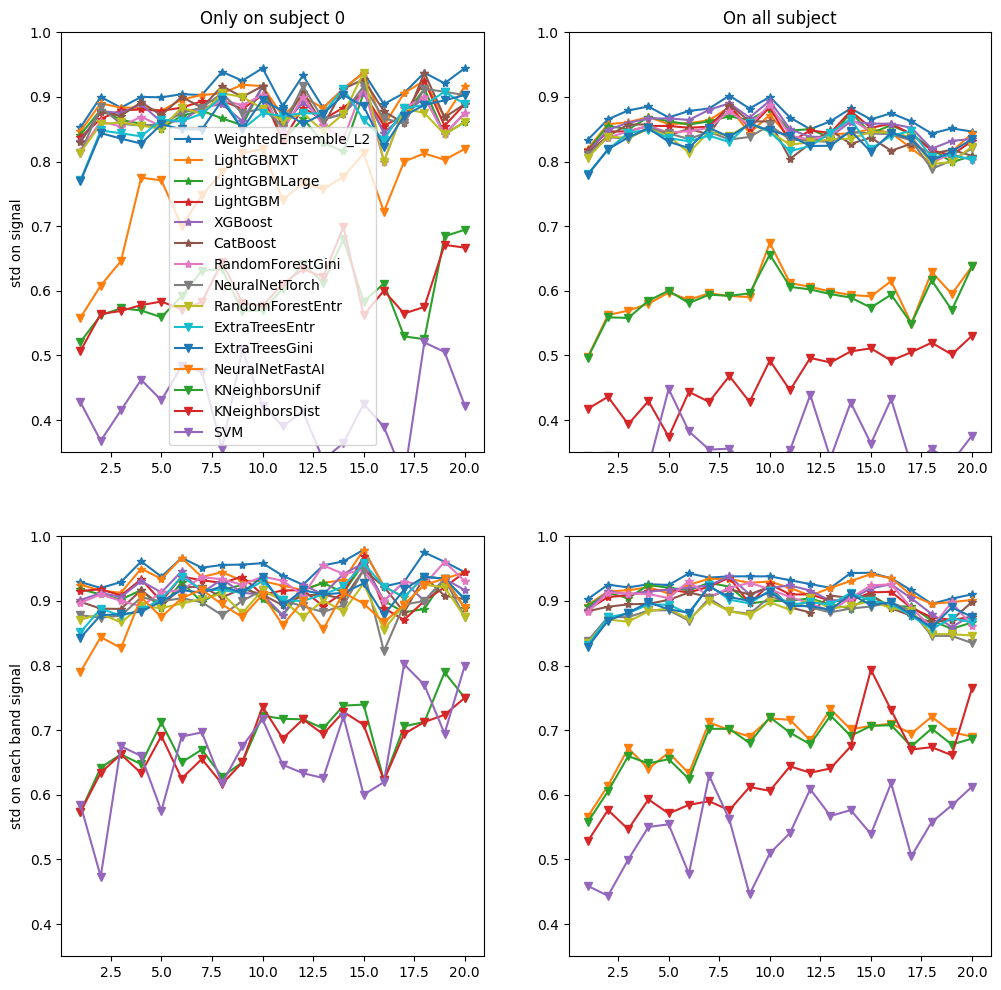

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

results = [sub0_std_signal, all_subs_std_signal, sub0_banded_std_signal, all_subs_banded_std_signal]
for i in range(len(results)):
    ax = axs[i//2][i%2]
    df = pd.concat(list(results[i].values()))
    models = df['model'].unique()
    lines = []
    for m, model in enumerate(models):
        x = df.loc[df['model'] == model, 'window']
        y = df.loc[df['model'] == model, 'score_val']
        marker = '*' if m < 7 else 'v'
        lines.append(ax.plot(x, y, label=model, marker=marker)[0])
    ax.set_ylim(.35, 1)
    if i == 0:
        ax.legend(handles=lines)
    if i == 0:
        ax.set_ylabel('std on signal')
        ax.set_title('Only on subject 0')
    if i == 1:
        ax.set_title('On all subject')
    if i == 2:
        ax.set_ylabel('std on each band signal')



In [13]:
import pickle

# Save the dictionary to a pickle file
subject_classic_models = {
    'sub0_std_signal': sub0_std_signal,
    'all_subs_std_signal': all_subs_std_signal,
    'sub0_banded_std_signal': sub0_banded_std_signal,
    'all_subs_banded_std_signal': all_subs_banded_std_signal,
}
with open('subject_classic_models.pickle', 'wb') as file:
    pickle.dump(subject_classic_models, file, protocol=pickle.HIGHEST_PROTOCOL)


In [10]:
# Load the dictionary from the pickle file
with open('subject_classic_models.pickle', 'rb') as file:
    loaded_dict = pickle.load(file)
loaded_dict

{'sub0_std_signal': {100:                   model  score_val  pred_time_val  fit_time  \
  0               XGBoost   0.866667       0.000000  0.440814   
  1   WeightedEnsemble_L2   0.866667       0.000000  1.068801   
  2         LightGBMLarge   0.866667       0.000000  0.987789   
  3              CatBoost   0.866667       0.000000  0.644398   
  4       NeuralNetFastAI   0.800000       0.000000  0.802705   
  5      RandomForestEntr   0.733333       0.031249  0.387330   
  6            LightGBMXT   0.666667       0.000000  0.912108   
  7              LightGBM   0.666667       0.000000  0.482805   
  8        KNeighborsDist   0.666667       0.000000  0.015628   
  9      RandomForestGini   0.666667       0.031249  0.424862   
  10       ExtraTreesGini   0.666667       0.046874  0.446004   
  11       ExtraTreesEntr   0.666667       0.046875  0.436608   
  12       NeuralNetTorch   0.533333       0.000000  0.502591   
  13       KNeighborsUnif   0.533333       0.004135  0.005002   
 

## Models On Spiking Resonators

### Random Forest on variance

In [196]:
import os
from pathlib import Path


class ResonatorSpikes:

    def __init__(self, clk_freq, resonator_freq, spikes_path):
        self.clk_freq = clk_freq
        self.resonator_freq = resonator_freq
        self.events = None
        self._load_spikes(spikes_path)

    def _load_spikes(self, spikes_path):
        spikes_array = np.load(spikes_path)['spikes']
        # if the file is already events based spikes
        if np.max(spikes_array[:3]) > 1:
            self.events = spikes_array
        else:
            self.events = np.where(spikes_array == 1)[0]

    def spectrogram(self, window_ms):
        window = int(self.clk_freq/1000 * window_ms)
        N = self.events[-1] // window + 1
        bins = np.zeros(N, dtype=int)
        unique_indices, counts = np.unique(np.array(self.events) // window, return_counts=True)
        bins[unique_indices] = counts
        return bins



class ChannelSpikes:

    def __init__(self, base_folder, channel_name):
        self.channel_name = channel_name
        self.resonators_output = {}
        self._load_resonators_output(base_folder)

    def _load_resonators_output(self, base_folder):
        channel_folder = base_folder / self.channel_name
        for clk_freq in os.listdir(channel_folder):
            clk_folder = channel_folder / clk_freq
            for spikes in os.listdir(clk_folder):
                resonator_freq = spikes[:-4]
                self.resonators_output[resonator_freq] = ResonatorSpikes(int(clk_freq), float(resonator_freq), f'{clk_folder}/{spikes}')

class SignalSpikes:

    def __init__(self, signal_folder, label):
        self.label = label
        self.channels = {
            channel: ChannelSpikes(signal_folder, channel)
            for channel in os.listdir(signal_folder)
        }


class Trial:

    def __init__(self, base_folder, trial):
        self.trial = trial
        self.base_folder = Path(f'{base_folder}/{trial}')

    def load(self, minute):
        # make sure it's in string format.
        minute = str(minute)
        for label in os.listdir(self.base_folder):
            labeled_minutes = os.listdir(self.base_folder / label)
            if minute in labeled_minutes:
                return SignalSpikes(self.base_folder / label / minute, label=label)
        return None

In [198]:
from tqdm.notebook import tqdm
spikes_data_folder = f'../datasets/EEG_data_for_Mental_Attention_State_Detection/EEG_spikes_clk/'
trials = os.listdir(spikes_data_folder)
trials = [3, 4, 5, 6, 7]
total_rows = []
with tqdm(total=len(trials) * 3 * 7 *len(channels) * 25) as pbar:
    for trial_number in trials:
        trial = Trial(f'../datasets/EEG_data_for_Mental_Attention_State_Detection/EEG_spikes_clk/', int(trial_number))
        focus_spikes = ('focus', [trial.load(i) for i in range(3, 10)])
        unfocus_spikes =  ('unfocus', [trial.load(i) for i in range(13, 20)])
        drowsed_spikes =  ('drowsed', [trial.load(i) for i in range(23, 30)])
        for label, ss_list in [focus_spikes, unfocus_spikes, drowsed_spikes]:
            for ss in ss_list:
                rows = [{'label': label}] * 4
                for ch in channels:
                    for res_freq, resonator in ss.channels[ch].resonators_output.items():
                        ten_ms_spectogram = resonator.spectrogram(10)
                        pbar.update(1)
                        for i in range(4):
                            rows[i][f'{ch}_{res_freq}'] = ten_ms_spectogram[i*(100*15):(i+1)*(100*15)].var()
                total_rows += rows

df = pd.DataFrame(total_rows)
df

,label,AF3_10.000,AF3_11.800,AF3_13.900,AF3_8.000,AF3_9.000,AF3_16.000,AF3_18.000,AF3_20.000,AF3_23.600,...,AF4_32.000,AF4_36.000,AF4_40.000,AF4_47.200,AF4_55.600,AF4_4.000,AF4_4.500,AF4_5.000,AF4_5.900,AF4_6.950
0,focus,0.616037,1.210073,0.692656,0.901289,1.244544,1.638793,2.957563,1.027780,3.482789,...,6.006292,3.098597,2.589100,41.980238,3.060311,0.568656,0.412469,0.404876,1.309989,0.482105
1,focus,0.616037,1.210073,0.692656,0.901289,1.244544,1.638793,2.957563,1.027780,3.482789,...,6.006292,3.098597,2.589100,41.980238,3.060311,0.568656,0.412469,0.404876,1.309989,0.482105
2,focus,0.616037,1.210073,0.692656,0.901289,1.244544,1.638793,2.957563,1.027780,3.482789,...,6.006292,3.098597,2.589100,41.980238,3.060311,0.568656,0.412469,0.404876,1.309989,0.482105
3,focus,0.616037,1.210073,0.692656,0.901289,1.244544,1.638793,2.957563,1.027780,3.482789,...,6.006292,3.098597,2.589100,41.980238,3.060311,0.568656,0.412469,0.404876,1.309989,0.482105
4,focus,0.588878,1.345093,0.624289,0.848122,1.269012,1.550583,2.894725,0.998052,3.291563,...,5.841900,3.010789,2.402686,12.738069,2.791358,0.586789,0.411600,0.386789,0.829178,0.467003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,drowsed,0.644100,2.912933,0.687264,0.912005,1.223886,1.579556,2.969998,1.110096,6.795866,...,4.590731,3.716400,2.697600,32.647226,3.308437,0.549377,0.445626,0.419584,1.344503,0.520833
416,drowsed,0.628698,2.898292,0.624666,0.787045,1.288186,1.509918,2.879937,1.120932,6.603578,...,5.603172,3.337216,2.742992,41.487300,2.880560,0.550192,0.415198,0.404112,1.288398,0.457545
417,drowsed,0.628698,2.898292,0.624666,0.787045,1.288186,1.509918,2.879937,1.120932,6.603578,...,5.603172,3.337216,2.742992,41.487300,2.880560,0.550192,0.415198,0.404112,1.288398,0.457545
418,drowsed,0.628698,2.898292,0.624666,0.787045,1.288186,1.509918,2.879937,1.120932,6.603578,...,5.603172,3.337216,2.742992,41.487300,2.880560,0.550192,0.415198,0.404112,1.288398,0.457545


In [200]:
classifiers_result = automl(df)
classifiers_result
#10,11,12,13. 19, 28
# [trial.load(i) for i in range(3, 10)]

No path specified. Models will be saved in: "AutogluonModels\ag-20230607_173345\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230607_173345\"
AutoGluon Version:  0.7.0
Python Version:     3.9.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22000
Train Data Rows:    336
Train Data Columns: 350
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	3 unique label values:  ['drowsed', 'unfocus', 'focus']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6933.18 MB
	Train Data (Original)  Memory Usage: 0.94 MB (0.0% of ava

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   1.000000       0.002000  2.485847                0.002000           2.485847            1       True         13
1   WeightedEnsemble_L2   1.000000       0.003000  2.811849                0.001000           0.326002            2       True         14
2            LightGBMXT   0.970588       0.003001  2.896572                0.003001           2.896572            1       True          4
3              LightGBM   0.970588       0.003002  1.006069                0.003002           1.006069            1       True          5
4               XGBoost   0.970588       0.004000  1.313223                0.004000           1.313223            1       True         11
5              CatBoost   0.970588       0.006999  6.213170                0.006999           6.213170            1       True          8
6       NeuralNetFastAI   0.970588

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,1.000000,0.002000,2.485847,0.002000,2.485847,1,True,13
1,WeightedEnsemble_L2,1.000000,0.003000,2.811849,0.001000,0.326002,2,True,14
2,LightGBMXT,0.970588,0.003001,2.896572,0.003001,2.896572,1,True,4
3,LightGBM,0.970588,0.003002,1.006069,0.003002,1.006069,1,True,5
4,XGBoost,0.970588,0.004000,1.313223,0.004000,1.313223,1,True,11
5,CatBoost,0.970588,0.006999,6.213170,0.006999,6.213170,1,True,8
6,NeuralNetFastAI,0.970588,0.012000,1.185527,0.012000,1.185527,1,True,3
7,KNeighborsDist,0.970588,0.023000,0.022000,0.023000,0.022000,1,True,2
8,NeuralNetTorch,0.970588,0.036000,0.930000,0.036000,0.930000,1,True,12
9,RandomForestGini,0.970588,0.038683,0.512001,0.038683,0.512001,1,True,6
